# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**

- для оценки качества моделей применяйте метрику RMSE.
- значение метрики RMSE должно быть меньше 2500.

**Описание данных:**

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

**План работы:**

1. Загрузка и изучение данных
2. Предобработка данных
3. Преобразование данных техникой OHE
4. Обучение 4-x моделей с подбором гиперпараметров: LightGBMRegressor, CatBoostRegressor, LinearRegression, RandomForestRegressor
5. Проверка на адекватность
6. Анализ моделей и выбор лучшей модели
7. Итоговый вывод


## Загрузка и изучение данных

In [1]:
!pip install catboost

In [2]:
pip install phik

In [3]:
pip install category_encoders

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time
import category_encoders as ce

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from IPython.display import display


In [5]:
RANDOM_STATE = 12345


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>


In [6]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('/content/autos.csv')

Первые 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Последние 5 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  o

None


Статистика по таблице:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Всего явных дубликатов: 4

Количество пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество пропусков в %:


DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Нулевые значения:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Гистограммы распределения признаков:


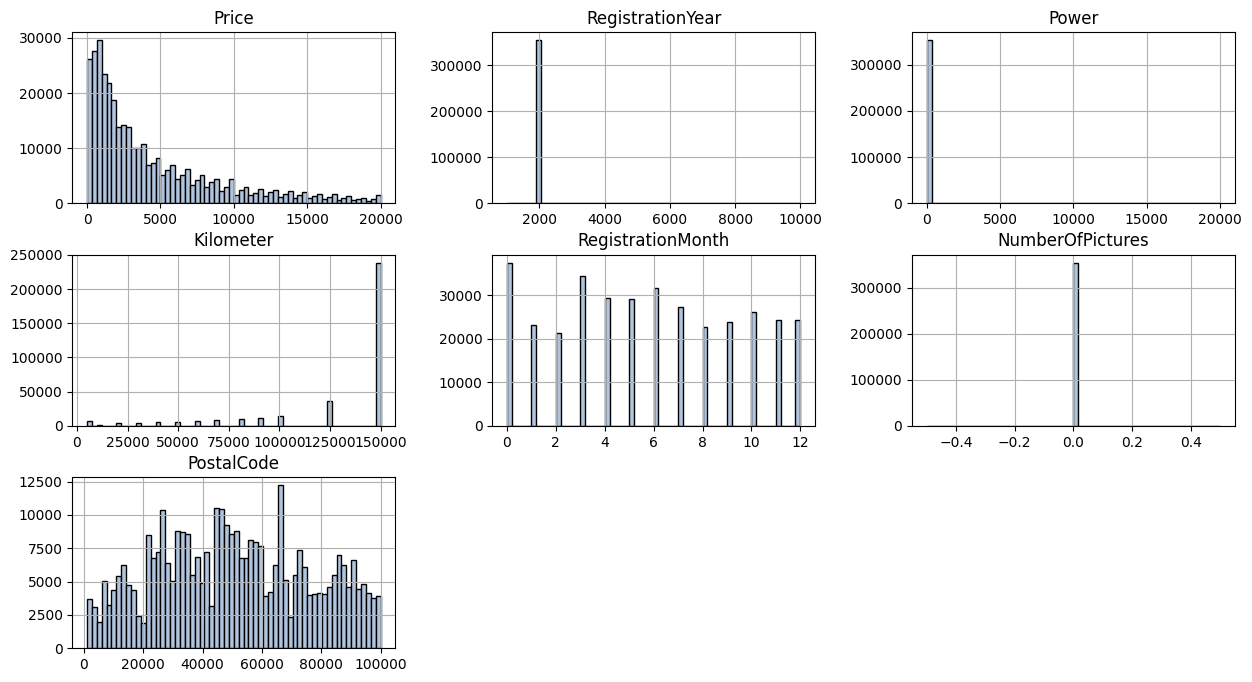

In [7]:
for _ in [data]:
    print('Первые 5 строк:')
    display(_.head())
    print()
    print('Последние 5 строк:')
    display(_.tail())
    print()
    print('Общая информация по таблице:')
    print()
    print(_.info())
    print()
    print('Статистика по таблице:')
    display(_.describe())
    print()
    print('Всего явных дубликатов:', _.duplicated().sum())
    print()
    print('Количество пропусков:')
    display(_.isna().sum())
    print('Количество пропусков в %:')
    display(_.isna().mean()*100)
    print('Нулевые значения:')
    print(_.isnull().sum())
    print('Гистограммы распределения признаков:')
    data.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightSteelBlue')

Посмотрим каким годом ограничены данные чтобы в дальнейшем оценить выбросы

In [8]:
print(data['DateCrawled'].sort_values().unique())
print(data['DateCreated'].sort_values().unique())

['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']
['2014-03-10 00:00:00' '2015-03-20 00:00:00' '2015-06-18 00:00:00'
 '2015-08-07 00:00:00' '2015-08-10 00:00:00' '2015-09-04 00:00:00'
 '2015-09-09 00:00:00' '2015-11-02 00:00:00' '2015-11-08 00:00:00'
 '2015-11-10 00:00:00' '2015-11-12 00:00:00' '2015-11-17 00:00:00'
 '2015-11-23 00:00:00' '2015-11-24 00:00:00' '2015-12-05 00:00:00'
 '2015-12-06 00:00:00' '2015-12-17 00:00:00' '2015-12-27 00:00:00'
 '2015-12-30 00:00:00' '2016-01-02 00:00:00' '2016-01-03 00:00:00'
 '2016-01-06 00:00:00' '2016-01-07 00:00:00' '2016-01-08 00:00:00'
 '2016-01-10 00:00:00' '2016-01-13 00:00:00' '2016-01-15 00:00:00'
 '2016-01-16 00:00:00' '2016-01-17 00:00:00' '2016-01-18 00:00:00'
 '2016-01-19 00:00:00' '2016-01-20 00:00:00' '2016-01-22 00:00:00'
 '2016-01-23 00:00:00' '2016-01-24 00:00:00' '2016-01-25 00:00:00'
 '2016-01-26 00:00:00' '2016-01-27 00:00:00' '2016-01-28 

### Вывод:
1. Всего 15 колонок с признаками, 1 целевой признак - цена авто, всего 354369 строк,  данные ограничены 2016 г включительно
2. Данные представляют собой: технические характеристики, комплектации и цены автомобилей, а также различные календарные метрики
3. Обнаружены нарушения хорошего стиля в названии колонок - нужно исправить
4. Обнаружены пропуски и нулевые значения:
 * VehicleType - 10.6% - большая доля пропусков - нужно разобраться, странно не указать тип кузова - основная характеристика
 * Gearbox - 5.6% - небольшая доля пропусков, но нужно разобраться, странно не указать тип коробки передач - основная характеристика
 * Model - 5.6% - небольшая доля пропусков, но нужно разобраться, странно не указать модель авто - основная характеристика
 * FuelType - 9.2%  - большая доля пропусков - нужно разобраться, странно не указать тип топлива - основная характеристика
 * Repaired - 20% - очень большая доля пропусков, возможно эти данные для машин, не бывших в ремонте просто не заполнялись

5. Обнаржены аномалии:
 * Price - минимум 0 - цена не указана - надо проверить, возможно хотят обмен или на металлолом
 * RegistrationYear	 - минимум - 1000, максимум - 9999 - явно ошибочное заполнение данных
 * Power - минимум 0 - мощность не указана в абсолютном большинстве - надо проверить, максимум 20 000 л с  - не верные данные
 * RegistrationMonth - 0 - не верная информация
 * NumberOfPictures	- данные не заполнены, либо везде отсутствуют фото что маловерятно - наверняка ошибка выгрузки
 * PostalCode - значения меньше 5 знаков вероятно с ошибками

5. Присутствуюи явные дубликаты в незначительном количестве, нужно еще проверить на неявные дубликаты
6. Не верный тип данных:
 * DateCrawled - исправить на datetime
 * Repaired - исправить на bool
 * DateCreated - исправить на datetime
 * LastSeen - исправить на datetime
7. Признаки, которые не влияют на стоимость авто -  
 * DateCrawled,
 * RegistrationMonth,
 * NumberOfPictures,
 * DateCreated
 * LastSeen,
 * PostalCode

эти данные можно удалить, соответственно исправлять в них пропуски/аномали и т д не требуется

## Предобработка данных

Удалим не нужные признаки из данных:

In [9]:
data.drop(columns={'DateCrawled', 'RegistrationMonth', 'NumberOfPictures',
                   'DateCreated', 'LastSeen', 'PostalCode'}, axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Приведение данных к "хорошему стилю"

In [10]:
data = data.rename(columns=str.lower)

In [11]:
data = data.rename(columns={'vehicletype' : 'vehicle_type',
                            'registrationyear' : 'registration_year',
                            'fueltype' : 'fuel_type'})

In [12]:
data.columns.unique()

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Обработка дубликатов

In [13]:
data[data.duplicated(keep=False)].sort_values("price")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
322235,0,wagon,2001,manual,101,focus,150000,petrol,ford,NaN
128790,0,small,2001,auto,45,NaN,125000,petrol,smart,no
326978,0,NaN,2016,manual,0,3er,150000,NaN,bmw,no
56156,0,NaN,2018,auto,55,fortwo,150000,NaN,smart,NaN
35698,0,wagon,1991,manual,0,passat,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
3728,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
100514,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
280897,20000,sedan,2011,auto,265,c_klasse,50000,gasoline,mercedes_benz,no
63806,20000,sedan,2007,auto,207,other,70000,gasoline,jaguar,no


In [14]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Обработка пропусков

#### Колонка 'vehicle_type'

In [15]:
display(data[data['vehicle_type'].isna()])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Удалять эти данные не будем- поставим заглушку - "unknown"

In [16]:
data.fillna({'vehicle_type':'unknown'}, inplace=True)
data['vehicle_type'].value_counts()

sedan          78206
small          67548
wagon          56367
unknown        34559
bus            25830
convertible    18195
coupe          14690
suv            10776
other           3158
Name: vehicle_type, dtype: int64

#### Колонка 'gearbox'

In [17]:
display(data[data['gearbox'].isna()])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
16,300,unknown,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,unknown,1990,NaN,0,corsa,150000,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354285,3500,small,2001,NaN,75,corsa,90000,petrol,opel,no
354305,3500,unknown,1995,NaN,0,polo,150000,NaN,volkswagen,NaN
354329,350,small,1996,NaN,65,punto,150000,NaN,fiat,NaN
354338,180,unknown,1995,NaN,0,NaN,125000,petrol,opel,NaN


Признак gearbox (тип коробки передач) достаточно важный и влиятельный на стоимость автомобиля, заполнить пропуски каким-либо значением нельзя - т к это может ощутимо исказить обучение моделей, поэтому принято решение эти данные удалить

In [18]:
data.dropna(subset=['gearbox'], inplace=True )
data['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

Для удобства заменим значения признака на численные 0 и 1, и изменим тип на int

In [19]:
data.loc[(data['gearbox'] == 'manual'), 'gearbox'] = 0
data.loc[(data['gearbox'] == 'auto'), 'gearbox'] = 1
data['gearbox'] = data['gearbox'].astype('int')
data['gearbox'].unique()

array([0, 1])

#### Колонка 'model'

In [20]:
display(data[data['model'].isna()])
data['model'].sort_values().unique()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,0,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,0,286,NaN,150000,NaN,sonstige_autos,NaN
81,350,small,1997,0,54,NaN,150000,NaN,fiat,yes
135,1450,sedan,1992,0,136,NaN,150000,NaN,audi,no
160,500,small,1999,0,0,NaN,150000,petrol,renault,no
...,...,...,...,...,...,...,...,...,...,...
354080,4300,small,2008,1,0,NaN,150000,NaN,honda,NaN
354234,5000,sedan,2002,1,170,NaN,150000,petrol,audi,no
354245,560,small,2001,1,170,NaN,90000,petrol,fiat,yes
354321,9400,wagon,2007,0,200,NaN,150000,gasoline,sonstige_autos,yes


array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Признак model (модель авто) очень важный и непосредственно влияет на стоимость автомобиля, заполнить пропуски каким-либо значением нельзя - т к это может ощутимо исказить обучение моделей, поэтому принято решение эти данные удалить

In [21]:
data.dropna(subset=['model'], inplace=True )
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

#### Колонка 'fuel_type'

In [22]:
display(data[data['fuel_type'].isna()])
data['fuel_type'].sort_values().unique()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
9,999,small,1998,0,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,0,131,passat,150000,NaN,volkswagen,no
26,5555,unknown,2017,0,125,c4,125000,NaN,citroen,no
36,1600,other,1991,0,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,1,306,e_klasse,150000,NaN,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...
354326,1300,small,1999,0,75,2_reihe,125000,NaN,peugeot,NaN
354327,2999,wagon,2004,0,234,vectra,100000,NaN,opel,NaN
354339,3850,convertible,2006,0,108,2_reihe,125000,NaN,peugeot,no
354346,2600,unknown,2005,1,0,c_klasse,150000,NaN,mercedes_benz,NaN


array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

Удалять эти данные не будем- поставим заглушку - "unknown"

In [23]:
data.fillna({'fuel_type':'unknown'}, inplace=True)
data['fuel_type'].value_counts()

petrol      173064
gasoline     79929
unknown      18919
lpg           4453
cng            494
hybrid         192
other          105
electric        59
Name: fuel_type, dtype: int64

**Расшифруем типы топлива:**
*    'cng'- (КПГ -компримированный (сжатый) природный газ)
*    'electric' - электричество
*    'gasoline' - бензин (название используется в США)
*    'hybrid' - гибрид (более 1 источника энергии)
*    'lpg'- (Liquefied petroleum gas) – сжиженный нефтяной газ, смесь сжиженных под давлением лёгких углеводородов
*    'other' - другой тип (например биодизельное топливо, солнечные батареи, биобутанол)
*    'petrol' - бензин (название используется в Великобритании, Индии)

Соответственно gasoline и petrol это одно и тоже, нужно объединить эти данные в одно наименование, объединим все в petrol

In [24]:
data.loc[data['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'
data['fuel_type'].value_counts()

petrol      252993
unknown      18919
lpg           4453
cng            494
hybrid         192
other          105
electric        59
Name: fuel_type, dtype: int64

#### Колонка 'repaired'

In [25]:
display(data[data['repaired'].isna()])
data['repaired'].sort_values().unique()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,0,0,golf,150000,petrol,volkswagen,NaN
2,9800,suv,2004,1,163,grand,125000,petrol,jeep,NaN
8,14500,bus,2014,0,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,0,101,golf,150000,unknown,volkswagen,NaN
12,999,wagon,1995,0,115,passat,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354346,2600,unknown,2005,1,0,c_klasse,150000,unknown,mercedes_benz,NaN
354349,5999,wagon,2005,0,140,a4,150000,petrol,audi,NaN
354356,999,convertible,2000,0,95,megane,150000,petrol,renault,NaN
354357,1690,wagon,2004,0,55,fabia,150000,petrol,skoda,NaN


array(['no', 'yes', nan], dtype=object)

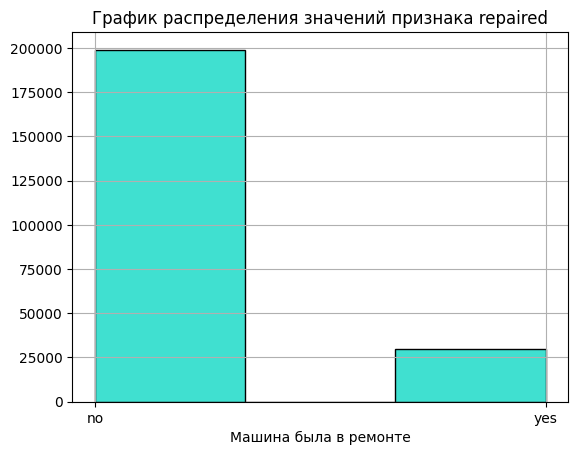

In [26]:
data['repaired'].hist(bins=3, color='turquoise',  edgecolor='black')
plt.title('График распределения значений признака repaired')
plt.xlabel('Машина была в ремонте')
plt.show()

Странное распределений значений для данных по машинам б/у, скорее всего пропущенные значение относятся к колонке = yes

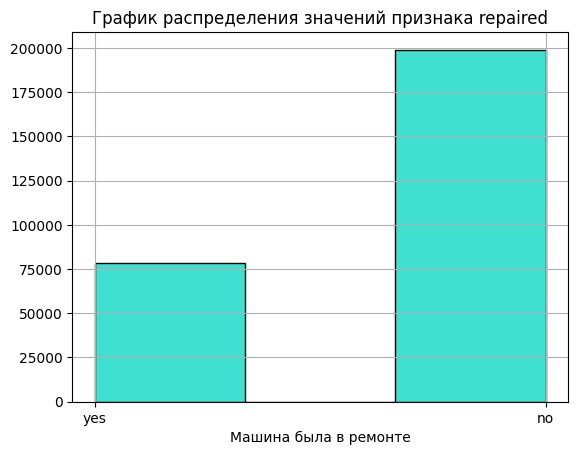

In [27]:
data.fillna({'repaired':'yes'}, inplace=True)
data['repaired'].hist(bins=3, color='turquoise',  edgecolor='black')
plt.title('График распределения значений признака repaired')
plt.xlabel('Машина была в ремонте')
plt.show()

Для удобства заменим значения признака на численные 0 и 1, и изменим тип на int

In [28]:
data.loc[(data['repaired'] == 'no'), 'repaired'] = 0
data.loc[(data['repaired'] == 'yes'), 'repaired'] = 1
data['repaired'] = data['repaired'].astype('int')


### Обработка аномалий

#### Целевой признак 'price'

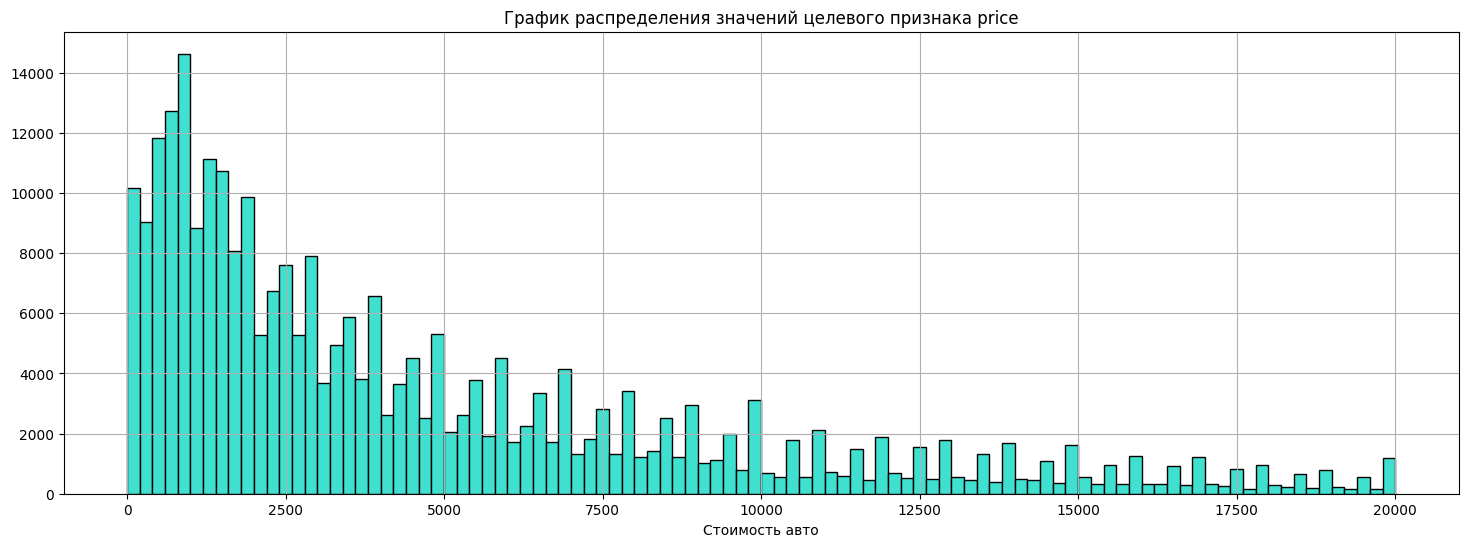

In [29]:
data['price'].hist(bins=100, edgecolor='LightSlateGrey', figsize=(18,6), color='turquoise')
plt.title('График распределения значений целевого признака price')
plt.xlabel('Стоимость авто')
plt.show()

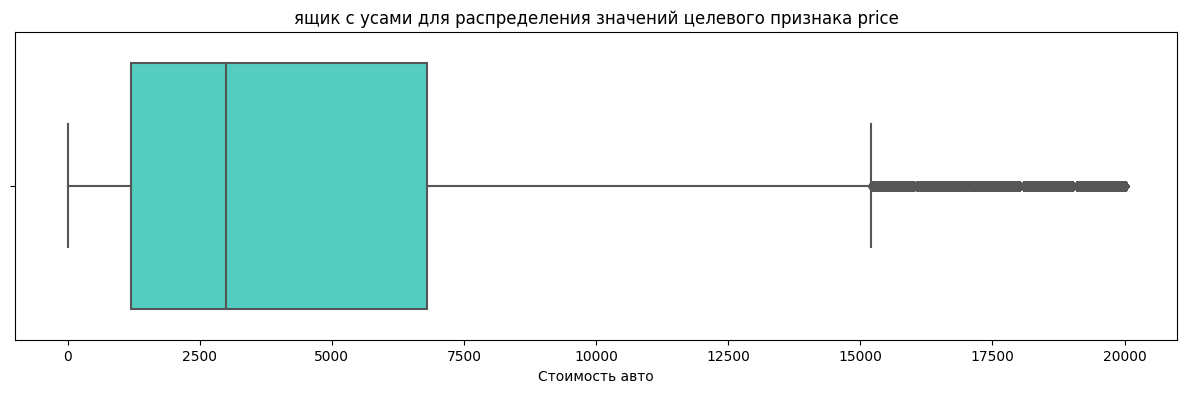

In [30]:
plt.figure(figsize=(15,4))
sns.boxplot( x='price', data=data, color='turquoise', orient='h')

plt.title('ящик с усами для распределения значений целевого признака price')
plt.xlabel('Стоимость авто')
plt.show()


In [31]:
data = data.query('price > 300')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261086 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              261086 non-null  int64 
 1   vehicle_type       261086 non-null  object
 2   registration_year  261086 non-null  int64 
 3   gearbox            261086 non-null  int64 
 4   power              261086 non-null  int64 
 5   model              261086 non-null  object
 6   kilometer          261086 non-null  int64 
 7   fuel_type          261086 non-null  object
 8   brand              261086 non-null  object
 9   repaired           261086 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 21.9+ MB


#### Колонка 'registration_year'

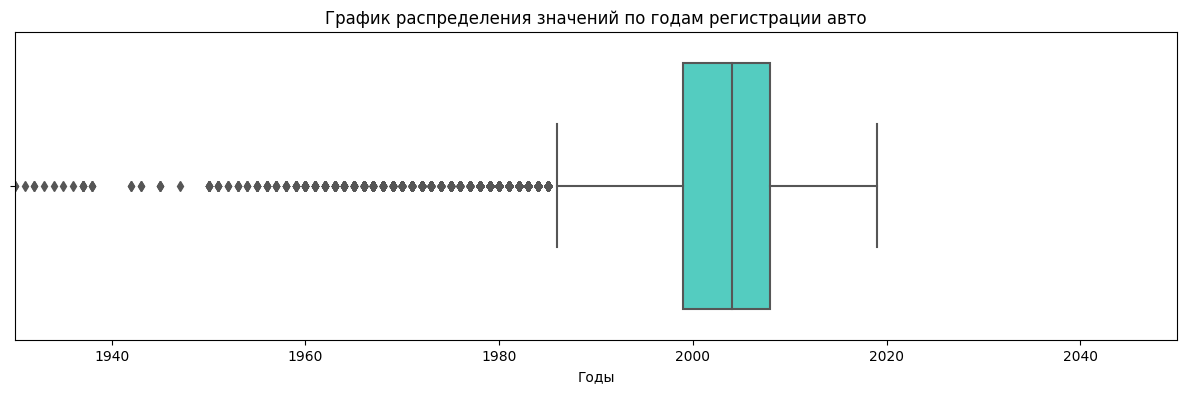

In [32]:
plt.figure(figsize=(15,4))
sns.boxplot( x='registration_year', data=data, color='turquoise', orient='h')
plt.xlim (1930, 2050)
plt.title('График распределения значений по годам регистрации авто')
plt.xlabel('Годы')
plt.show()

In [33]:
data['registration_year'].sort_values().unique()

array([1000, 1400, 1500, 1600, 1602, 1910, 1923, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1942, 1943, 1945,
       1947, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2900, 3700, 4000, 4500, 5000, 5911,
       6000, 7100, 8200])

In [34]:
data['registration_year'].quantile([0.05, 0.95])

0.05    1993.0
0.95    2016.0
Name: registration_year, dtype: float64

По этому признаку выбросов очень много, и хотя выбросы слева до 1993 г - удалим данные до 1960( т к могли быть в продаже и ретро автомобили) и после 2016( т к данные ограничены 2016 годом - регистрация годами выше быть не может)

In [35]:
data = data.query('1960 < registration_year < 2016 ')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245732 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              245732 non-null  int64 
 1   vehicle_type       245732 non-null  object
 2   registration_year  245732 non-null  int64 
 3   gearbox            245732 non-null  int64 
 4   power              245732 non-null  int64 
 5   model              245732 non-null  object
 6   kilometer          245732 non-null  int64 
 7   fuel_type          245732 non-null  object
 8   brand              245732 non-null  object
 9   repaired           245732 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 20.6+ MB


#### Колонка 'power'

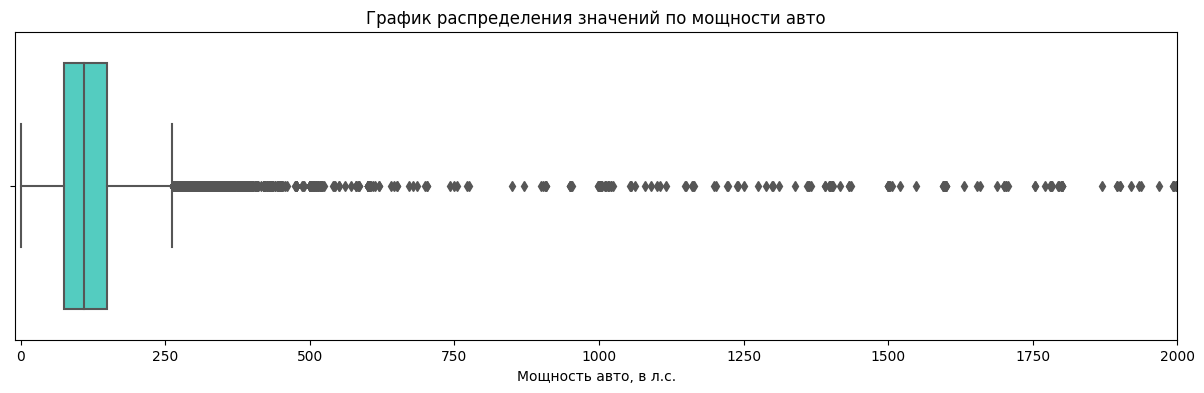

In [36]:
plt.figure(figsize=(15,4))
sns.boxplot( x='power', data=data, color='turquoise', orient='h')
plt.xlim (-10, 2000)
plt.title('График распределения значений по мощности авто')
plt.xlabel('Мощность авто, в л.с.')
plt.show()

https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html
https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output

По найденой информации минимальная мощность у ретро авто выпускаемого до 1990г - 9 л.с., а максимальная у авто с выпуском до 2016 г включительно - 1500 л.с. Удалим выбросы за пределами этих значений

In [37]:
data = data.query('9 < power < 1500 ')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230208 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              230208 non-null  int64 
 1   vehicle_type       230208 non-null  object
 2   registration_year  230208 non-null  int64 
 3   gearbox            230208 non-null  int64 
 4   power              230208 non-null  int64 
 5   model              230208 non-null  object
 6   kilometer          230208 non-null  int64 
 7   fuel_type          230208 non-null  object
 8   brand              230208 non-null  object
 9   repaired           230208 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 19.3+ MB


#### Колонка 'brand'


In [38]:
data['brand'].value_counts()

volkswagen       47222
bmw              25686
opel             23474
mercedes_benz    22998
audi             20766
ford             15859
renault          10542
peugeot           7337
fiat              5885
seat              4700
skoda             4262
mazda             3851
citroen           3576
toyota            3487
smart             3261
nissan            3244
hyundai           2628
mini              2544
volvo             2355
mitsubishi        2032
honda             2003
kia               1763
alfa_romeo        1640
suzuki            1619
chevrolet         1274
chrysler           998
dacia              702
porsche            549
subaru             540
jeep               510
daihatsu           473
land_rover         413
jaguar             408
saab               404
daewoo             315
lancia             300
rover              260
trabant            192
lada               136
Name: brand, dtype: int64

Аномали, неявные дубликаты не обнаружены

<ipython-input-39-bbf00844e65c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<Axes: >

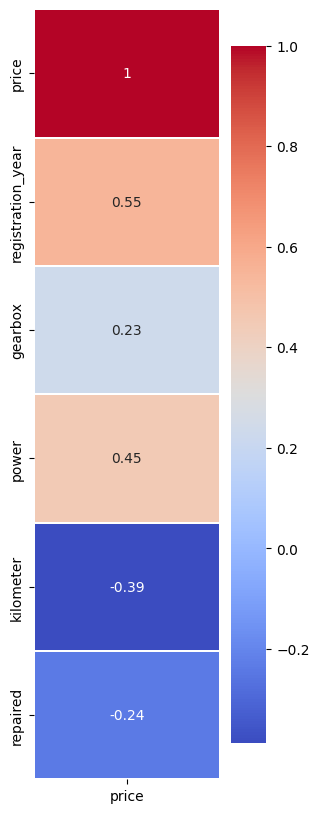

In [39]:
fig, ax = plt.subplots(figsize=(3, 10))
correlation = data.corr()
sns.heatmap(correlation[['price']], linewidths=.3, annot=True, cmap='coolwarm')

In [40]:
data.phik_matrix()

interval columns not set, guessing: ['price', 'registration_year', 'gearbox', 'power', 'kilometer', 'repaired']


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.244404,0.677732,0.300704,0.414662,0.567026,0.314377,0.089888,0.323797,0.353438
vehicle_type,0.244404,1.000000,0.166841,0.206109,0.265812,0.906455,0.272121,0.173220,0.598634,0.130464
registration_year,0.677732,0.166841,1.000000,0.090230,0.145169,0.645284,0.423595,0.092948,0.319847,0.237655
gearbox,0.300704,0.206109,0.090230,1.000000,0.535924,0.634329,0.049209,0.067267,0.490734,0.042453
power,0.414662,0.265812,0.145169,0.535924,1.000000,0.629094,0.073030,0.080545,0.433443,0.075122
model,0.567026,0.906455,0.645284,0.634329,0.629094,1.000000,0.454684,0.368811,0.998349,0.153367
kilometer,0.314377,0.272121,0.423595,0.049209,0.073030,0.454684,1.000000,0.082080,0.273120,0.141894
fuel_type,0.089888,0.173220,0.092948,0.067267,0.080545,0.368811,0.082080,1.000000,0.251576,0.113571
brand,0.323797,0.598634,0.319847,0.490734,0.433443,0.998349,0.273120,0.251576,1.000000,0.078550
repaired,0.353438,0.130464,0.237655,0.042453,0.075122,0.153367,0.141894,0.113571,0.078550,1.000000


### Вывод:
1. Удалены признаки, которые не влияют на стоимость авто:  
 * DateCrawled,
 * RegistrationMonth,
 * NumberOfPictures,
 * DateCreated
 * LastSeen,
 * PostalCode

2. Наименования колонок приведены к "хорошему стилю"
3. Явные дубликаты удалены. Неявные дубликаты не обнаружены
4. Пропуски в
 * vehicle_type - 10.6% - поставили заглушку "unknown"
 * gearbox -5.6% удалены, т к ничем нельзя заплнить - повлияет на обучение моделей
 * Model - 5.6% - удалены, т к ничем нельзя заплнить - повлияет на обучение моделей
 * FuelType - 9.2%  - поставили заглушку "unknown"
 * Repaired - 20% - проверили распределение признака, заполнили значением "yes", т к подозрительно превалирующее количество машин отмечены как "не были в ремонте"

5. Удалены выбросы и аномалии в колонках:
 * price
 * registration_year
 * power
6. Прямая корреляция наблюдается у целевого признака с регистрацией авто, достаточно высокая с мощностью авто и обратная корреляция у целевого признака с пробегом авто
6. Всего готово к исследованию 217242 строк, 9 колонок с признаками и 1 целевой признак

## Обучение моделей

### Разбиение на выборки.

In [41]:
target = data['price']
features = data.drop('price', axis=1)

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=RANDOM_STATE)


print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(138124, 9)
(138124,)
(46042, 9)
(46042,)
(46042, 9)
(46042,)


### Преобразование данных техникой TargetEncoder, GLMMEncoder

In [42]:
glmm_encoder = ce.GLMMEncoder(cols=['vehicle_type', 'registration_year',
                                    'power', 'model', 'kilometer', 'fuel_type', 'brand'], binomial_target=False)
#gearbox и repaired уже бинарные, не включаю в кодирование
# binomial_target = True (for Classification)
# binomial_target = False (for Regression)

glmm_encoder.fit(features_train, target_train)
features_train_glmme = glmm_encoder.transform(features_train)
features_valid_glmme = glmm_encoder.transform(features_valid)
features_test_glmme = glmm_encoder.transform(features_test)

# смотрим на результат
features_train_glmme.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
268760,976.160306,-2873.386482,1,77.101593,573.682732,-4076.368055,-219.318478,1513.734852,0
288549,-2190.059000,-4284.783688,0,-4554.161228,-600.326905,-4076.368055,-219.318478,1957.000926,0
216441,-1504.983756,-21.919838,0,746.172623,259.996732,-4076.368055,-219.318478,-1064.208413,0
347270,205.034517,-4171.795411,0,-3782.889676,-1261.724697,-2356.685565,-219.318478,138.129558,0
279488,205.034517,-4818.679632,0,-2294.002074,1163.175884,-4076.368055,-219.318478,382.630552,0


In [43]:
te_encoder = ce.TargetEncoder(cols=['vehicle_type', 'registration_year',
                                    'power', 'model', 'kilometer', 'fuel_type', 'brand'], smoothing=2 )
#gearbox и repaired уже бинарные, не включаю в кодирование
#smoothing=2 - (сглаживание) по идее этот параметр надо перебрать в цикле,
#но пока не поняла как это технически сделать с учетом обучения моделей
te_encoder.fit(features_train, target_train)
features_train_te = te_encoder.transform(features_train)
features_valid_te = te_encoder.transform(features_valid)
features_test_te = te_encoder.transform(features_test)

# смотрим на результат
features_train_te.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
268760,6594.128575,3611.744855,1,7387.304749,6742.339100,4008.645322,5328.917987,6476.697315,0
288549,3420.466503,2200.182734,0,2749.406998,5567.596310,4008.645322,5328.917987,6920.042664,0
216441,4106.051282,6463.506495,0,8056.455508,6428.736390,4008.645322,5328.917987,3897.828809,0
347270,5822.411221,2310.711059,0,3514.862500,4906.153234,5727.951037,5328.917987,5100.916948,0
279488,5822.411221,1665.258597,0,5015.346243,7331.726577,4008.645322,5328.917987,5345.194827,0


#### LightGBMRegressor

##### На выборке с GLMMEncoder

In [44]:
%%time

model_LGBMR = LGBMRegressor()
parameters = [{'num_leaves': [20, 50, 100, 200], 'learning_rate':[0.3, 0.5, 0.8], 'n_estimators':[100, 200, 500], 'random_state':[RANDOM_STATE]}]

model_LGBMR_selection = GridSearchCV(model_LGBMR, parameters, scoring='neg_mean_squared_error')
model_LGBMR_selection.fit(features_train_glmme, target_train)

print(model_LGBMR_selection.best_params_)

mts = model_LGBMR_selection.cv_results_['mean_test_score']

rsme_LGBMR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели LightGBMRegressor на выборке с GLMMEncoder:', rsme_LGBMR)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Info] Start training from score 5235.709002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Info] Start training from score 5230.596648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Inf

{'learning_rate': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'random_state': RANDOM_STATE}

RMSE на лучшей модели LightGBMRegressor на выборке с GLMMEncoder: 1625.9323907922362


In [45]:
%%time
model_LGBMR = LGBMRegressor(num_leaves=50, learning_rate=0.3, n_estimators=500, random_state=RANDOM_STATE)
start = time.time()
model_LGBMR.fit(features_train_glmme, target_train)
end = time.time()
t_lg_gl_1=round(end-start,2)
start = time.time()
predict_LGBMR = model_LGBMR.predict(features_valid_glmme)
end = time.time()
t_lg_gl_2=round(end-start,2)
rsme_LGBMR_gl = mean_squared_error(target_valid, predict_LGBMR) ** 0.5
print ('RMSE на лучшей модели LightGBMRegressor на валидационной выборке с GLMMEncoder:', rsme_LGBMR_gl)
print ('Время обучения:',t_lg_gl_1, ', скорость предсказания:',t_lg_gl_2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 138124, number of used features: 9
[LightGBM] [Info] Start training from score 5233.008695
RMSE на лучшей модели LightGBMRegressor на валидационной выборке с GLMMEncoder: 1606.4751457546795
Время обучения: 4.72 , скорость предсказания: 1.07
CPU times: user 5.69 s, sys: 45.7 ms, total: 5.73 s
Wall time: 5.79 s


##### На выборке с TargetEncoder

In [46]:
%%time

model_LGBMR = LGBMRegressor()
parameters = [{'num_leaves': [20, 50, 100, 200], 'learning_rate':[0.3, 0.5, 0.8], 'n_estimators':[100, 200, 500], 'random_state':[RANDOM_STATE]}]

model_LGBMR_selection = GridSearchCV(model_LGBMR, parameters, scoring='neg_mean_squared_error')
model_LGBMR_selection.fit(features_train_te, target_train)

print(model_LGBMR_selection.best_params_)

mts = model_LGBMR_selection.cv_results_['mean_test_score']

rsme_LGBMR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели LightGBMRegressor на выборке с TargetEncoder:', rsme_LGBMR)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Info] Start training from score 5235.709002
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Info] Start training from score 5230.596648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 110499, number of used features: 9
[LightGBM] [Inf

{'learning_rate': 0.3, 'n_estimators': 500, 'num_leaves': 50, 'random_state': 12345}

RMSE на лучшей модели LightGBMRegressor: 1632.920583831211


In [47]:
%%time
model_LGBMR = LGBMRegressor(num_leaves=50, learning_rate=0.3, n_estimators=500, random_state=RANDOM_STATE)
start = time.time()
model_LGBMR.fit(features_train_te, target_train)
end = time.time()
t_lg_te_1=round(end-start,2)
start = time.time()
predict_LGBMR = model_LGBMR.predict(features_valid_te)
end = time.time()
t_lg_te_2=round(end-start,2)
rsme_LGBMR_te = mean_squared_error(target_valid, predict_LGBMR) ** 0.5
print ('RMSE на лучшей модели LightGBMRegressor на валидационной выборке с TargetEncoder:', rsme_LGBMR_te)
print ('Время обучения:',t_lg_te_1, ', скорость предсказания:',t_lg_te_2)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 138124, number of used features: 9
[LightGBM] [Info] Start training from score 5233.008695
RMSE на лучшей модели LightGBMRegressor на валидационной выборке с TargetEncoder: 1623.6445809848954
Время обучения: 3.8 , скорость предсказания: 1.05
CPU times: user 4.82 s, sys: 33.1 ms, total: 4.86 s
Wall time: 4.86 s


#### CatBoostRegressor


##### На выборке с GLMMEncoder

In [48]:
%%time

model_CBR = CatBoostRegressor()
parameters = [{'iterations': [50, 100, 200, 500], 'learning_rate':[0.05, 0.3, 0.5, 0.8], 'depth':[2, 10, 25, 100], 'random_state':[RANDOM_STATE]}]

model_CBR_selection = GridSearchCV(model_CBR, parameters, scoring='neg_mean_squared_error')
model_CBR_selection.fit(features_train_glmme, target_train)

print(model_CBR_selection.best_params_)

mts = model_CBR_selection.cv_results_['mean_test_score']

rsme_CBR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели CatBoostRegressor на выборке с GLMMEncoder', rsme_CBR)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 3113.7888727	total: 35.3ms	remaining: 17.6s
1:	learn: 2405.7545917	total: 69.9ms	remaining: 17.4s
2:	learn: 2104.8267465	total: 105ms	remaining: 17.4s
3:	learn: 1972.8984774	total: 140ms	remaining: 17.3s
4:	learn: 1903.1070885	total: 187ms	remaining: 18.5s
5:	learn: 1874.6586687	total: 224ms	remaining: 18.5s
6:	learn: 1852.1663998	total: 269ms	remaining: 19s
7:	learn: 1834.2266353	total: 306ms	remaining: 18.8s
8:	learn: 1820.1825785	total: 343ms	remaining: 18.7s
9:	learn: 1801.6828723	total: 377ms	remaining: 18.5s
10:	learn: 1789.8116709	total: 417ms	remaining: 18.6s
11:	learn: 1779.7732740	total: 452ms	remaining: 18.4s
12:	learn: 1767.3624607	total: 495ms	remaining: 18.5s
13:	learn: 1753.8746243	total: 531ms	remaining: 18.4s
14:	learn: 1748.9900857	total: 565ms	remaining: 18.3s
15:	learn: 1741.2161371	total: 600ms	remaining: 18.1s
16:	learn: 1735.6077215	total: 635ms	remaining: 18s
17:	learn: 1728.0519648	to

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5704, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_p

0:	learn: 3690.0428976	total: 43.9ms	remaining: 21.9s
1:	learn: 3014.6381796	total: 85.8ms	remaining: 21.4s
2:	learn: 2588.0849997	total: 134ms	remaining: 22.2s
3:	learn: 2311.7823993	total: 185ms	remaining: 23s
4:	learn: 2149.6952241	total: 230ms	remaining: 22.8s
5:	learn: 2046.1004656	total: 277ms	remaining: 22.8s
6:	learn: 1979.3339163	total: 319ms	remaining: 22.4s
7:	learn: 1934.3744477	total: 361ms	remaining: 22.2s
8:	learn: 1904.4762682	total: 402ms	remaining: 21.9s
9:	learn: 1878.9812608	total: 442ms	remaining: 21.7s
10:	learn: 1859.0591113	total: 491ms	remaining: 21.8s
11:	learn: 1841.0162881	total: 538ms	remaining: 21.9s
12:	learn: 1829.4382704	total: 578ms	remaining: 21.7s
13:	learn: 1816.8940153	total: 627ms	remaining: 21.8s
14:	learn: 1808.2894028	total: 668ms	remaining: 21.6s
15:	learn: 1801.6221990	total: 714ms	remaining: 21.6s
16:	learn: 1791.5354731	total: 755ms	remaining: 21.5s
17:	learn: 1781.2860559	total: 796ms	remaining: 21.3s
18:	learn: 1772.3773446	total: 837ms	r

{'depth': 10, 'iterations': 500, 'learning_rate': 0.3, 'random_state': 12345}

RMSE на лучшей модели CatBoostRegressor: 1620.9171336535296


In [49]:
%%time
model_CBR = CatBoostRegressor(iterations=500, learning_rate=0.3, depth=10, random_state=RANDOM_STATE)
start = time.time()
model_CBR.fit(features_train_glmme, target_train)
end = time.time()
t_cbr_gl_1=round(end-start,2)
start = time.time()
predict_CBR = model_CBR.predict(features_valid_glmme)
end = time.time()
t_cbr_gl_2=round(end-start,2)
rsme_CBR_gl = mean_squared_error(target_valid, predict_CBR) ** 0.5
print ('RMSE на лучшей модели CatBoostRegressor на валидационной выборке с GLMMEncoder:', rsme_CBR_gl)
print ('Время обучения:',t_cbr_gl_1, ', скорость предсказания:',t_cbr_gl_2)

0:	learn: 3690.0428976	total: 46.1ms	remaining: 23s
1:	learn: 3014.6381796	total: 97.4ms	remaining: 24.3s
2:	learn: 2588.0849997	total: 140ms	remaining: 23.1s
3:	learn: 2311.7823993	total: 186ms	remaining: 23s
4:	learn: 2149.6952241	total: 230ms	remaining: 22.7s
5:	learn: 2046.1004656	total: 276ms	remaining: 22.7s
6:	learn: 1979.3339163	total: 330ms	remaining: 23.2s
7:	learn: 1934.3744477	total: 375ms	remaining: 23.1s
8:	learn: 1904.4762682	total: 419ms	remaining: 22.9s
9:	learn: 1878.9812608	total: 459ms	remaining: 22.5s
10:	learn: 1859.0591113	total: 519ms	remaining: 23.1s
11:	learn: 1841.0162881	total: 570ms	remaining: 23.2s
12:	learn: 1829.4382704	total: 611ms	remaining: 22.9s
13:	learn: 1816.8940153	total: 652ms	remaining: 22.6s
14:	learn: 1808.2894028	total: 693ms	remaining: 22.4s
15:	learn: 1801.6221990	total: 746ms	remaining: 22.6s
16:	learn: 1791.5354731	total: 787ms	remaining: 22.3s
17:	learn: 1781.2860559	total: 828ms	remaining: 22.2s
18:	learn: 1772.3773446	total: 868ms	rem

##### На выборке с TargetEncoder

In [50]:
%%time

model_CBR = CatBoostRegressor()
parameters = [{'iterations': [50, 100, 200, 500], 'learning_rate':[0.05, 0.3, 0.5, 0.8], 'depth':[2, 10, 25, 100], 'random_state':[12345]}]

model_CBR_selection = GridSearchCV(model_CBR, parameters, scoring='neg_mean_squared_error')
model_CBR_selection.fit(features_train_te, target_train)

print(model_CBR_selection.best_params_)

mts = model_CBR_selection.cv_results_['mean_test_score']

rsme_CBR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели CatBoostRegressor на выборке с TargetEncoder:', rsme_CBR)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 3150.2536702	total: 36.4ms	remaining: 18.1s
1:	learn: 2449.3274599	total: 79.4ms	remaining: 19.8s
2:	learn: 2130.0021934	total: 115ms	remaining: 19s
3:	learn: 2006.7058037	total: 151ms	remaining: 18.7s
4:	learn: 1951.9543352	total: 187ms	remaining: 18.5s
5:	learn: 1909.3236346	total: 222ms	remaining: 18.3s
6:	learn: 1887.1777466	total: 269ms	remaining: 18.9s
7:	learn: 1869.1914371	total: 306ms	remaining: 18.8s
8:	learn: 1849.8580822	total: 347ms	remaining: 19s
9:	learn: 1836.6149938	total: 382ms	remaining: 18.7s
10:	learn: 1818.6580185	total: 417ms	remaining: 18.6s
11:	learn: 1807.8953003	total: 453ms	remaining: 18.4s
12:	learn: 1791.9394433	total: 496ms	remaining: 18.6s
13:	learn: 1779.3482523	total: 549ms	remaining: 19s
14:	learn: 1768.7133893	total: 589ms	remaining: 19s
15:	learn: 1764.3201285	total: 627ms	remaining: 19s
16:	learn: 1751.5385750	total: 661ms	remaining: 18.8s
17:	learn: 1745.6859375	total: 7

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5704, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_p

0:	learn: 3702.7578642	total: 44.3ms	remaining: 22.1s
1:	learn: 3024.3273872	total: 86.7ms	remaining: 21.6s
2:	learn: 2601.6160039	total: 131ms	remaining: 21.7s
3:	learn: 2331.0806206	total: 178ms	remaining: 22.1s
4:	learn: 2163.3968717	total: 219ms	remaining: 21.7s
5:	learn: 2070.0058911	total: 267ms	remaining: 22s
6:	learn: 2001.0597523	total: 308ms	remaining: 21.7s
7:	learn: 1957.2092800	total: 360ms	remaining: 22.2s
8:	learn: 1925.6302813	total: 405ms	remaining: 22.1s
9:	learn: 1900.6085217	total: 447ms	remaining: 21.9s
10:	learn: 1878.3055176	total: 497ms	remaining: 22.1s
11:	learn: 1860.1223829	total: 541ms	remaining: 22s
12:	learn: 1846.1671388	total: 583ms	remaining: 21.8s
13:	learn: 1832.3656810	total: 626ms	remaining: 21.7s
14:	learn: 1824.4960575	total: 668ms	remaining: 21.6s
15:	learn: 1815.7472721	total: 717ms	remaining: 21.7s
16:	learn: 1807.0190992	total: 765ms	remaining: 21.7s
17:	learn: 1799.1128109	total: 808ms	remaining: 21.6s
18:	learn: 1790.2307359	total: 856ms	rem

{'depth': 10, 'iterations': 500, 'learning_rate': 0.3, 'random_state': 12345}

RMSE на лучшей модели CatBoostRegressor: 1628.6802294694896


In [51]:
%%time
model_CBR = CatBoostRegressor(iterations=500, learning_rate=0.3, depth=10, random_state=RANDOM_STATE)
start = time.time()
model_CBR.fit(features_train_te, target_train)
end = time.time()
t_cbr_te_1=round(end-start,2)
start = time.time()
predict_CBR = model_CBR.predict(features_valid_te)
end = time.time()
t_cbr_te_2=round(end-start,2)
rsme_CBR_te = mean_squared_error(target_valid, predict_CBR) ** 0.5
print ('RMSE на лучшей модели CatBoostRegressor на валидационной выборке с TargetEncoder:', rsme_CBR_te)
print ('Время обучения:',t_cbr_te_1, ', скорость предсказания:',t_cbr_te_2)

0:	learn: 3702.7578642	total: 42.2ms	remaining: 21.1s
1:	learn: 3024.3273872	total: 87.3ms	remaining: 21.7s
2:	learn: 2601.6160039	total: 132ms	remaining: 21.9s
3:	learn: 2331.0806206	total: 174ms	remaining: 21.6s
4:	learn: 2163.3968717	total: 216ms	remaining: 21.4s
5:	learn: 2070.0058911	total: 261ms	remaining: 21.5s
6:	learn: 2001.0597523	total: 303ms	remaining: 21.3s
7:	learn: 1957.2092800	total: 352ms	remaining: 21.6s
8:	learn: 1925.6302813	total: 392ms	remaining: 21.4s
9:	learn: 1900.6085217	total: 448ms	remaining: 22s
10:	learn: 1878.3055176	total: 514ms	remaining: 22.8s
11:	learn: 1860.1223829	total: 555ms	remaining: 22.6s
12:	learn: 1846.1671388	total: 600ms	remaining: 22.5s
13:	learn: 1832.3656810	total: 641ms	remaining: 22.3s
14:	learn: 1824.4960575	total: 684ms	remaining: 22.1s
15:	learn: 1815.7472721	total: 735ms	remaining: 22.2s
16:	learn: 1807.0190992	total: 776ms	remaining: 22.1s
17:	learn: 1799.1128109	total: 820ms	remaining: 21.9s
18:	learn: 1790.2307359	total: 863ms	r

#### LinearRegression


##### На выборке с GLMMEncoder

In [52]:
%%time

model_LR = LinearRegression()
start = time.time()
model_LR.fit(features_train_glmme, target_train)
end = time.time()
t_lr_gl_1=round(end-start,2)
start = time.time()
predict_LR = model_LR.predict(features_valid_glmme)
end = time.time()
t_lr_gl_2=round(end-start,2)
rsme_LR_gl = mean_squared_error(target_valid, predict_LR) ** 0.5
print ('RMSE на лучшей модели LinearRegression на валидационной выборке с GLMMEncoder:', rsme_LR_gl)
print ('Время обучения:',t_lr_gl_1, ', скорость предсказания:',t_lr_gl_2)

RMSE на лучшей модели LinearRegression на валидационной выборке с GLMMEncoder: 2315.17407009729
Время обучения: 0.06 , скорость предсказания: 0.01
CPU times: user 69.2 ms, sys: 21 ms, total: 90.2 ms
Wall time: 66.9 ms


##### На выборке с TargetEncoder

In [53]:
%%time

model_LR = LinearRegression()
start = time.time()
model_LR.fit(features_train_te, target_train)
end = time.time()
t_lr_te_1=round(end-start,2)
start = time.time()
predict_LR = model_LR.predict(features_valid_te)
end = time.time()
t_lr_te_2=round(end-start,2)

rsme_LR_te = mean_squared_error(target_valid, predict_LR) ** 0.5
print ('RMSE на лучшей модели LinearRegression на валидационной выборке с TargetEncoder:', rsme_LR_te)
print ('Время обучения:',t_lr_te_1, ', скорость предсказания:',t_lr_te_2)

RMSE на лучшей модели LinearRegression на валидационной выборке с TargetEncoder: 2331.7021434152934
Время обучения: 0.1 , скорость предсказания: 0.01
CPU times: user 94.9 ms, sys: 94.4 ms, total: 189 ms
Wall time: 109 ms


#### RandomForestRegressor

##### На выборке с GLMMEncoder

In [54]:
%%time

model_RFR = RandomForestRegressor()
parameters = [{'n_estimators': [10, 100], 'max_depth':[2, 20], 'random_state':[RANDOM_STATE]}]

model_RFR_selection = GridSearchCV(model_RFR, parameters, scoring='neg_mean_squared_error')
model_RFR_selection.fit(features_train_glmme, target_train)

print(model_RFR_selection.best_params_)

mts = model_RFR_selection.cv_results_['mean_test_score']

rsme_RFR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели RandomForestRegressor на выборке с GLMMEncoder:', rsme_RFR)

{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}
RMSE на лучшей модели RandomForestRegressor на выборке с GLMMEncoder: 1708.596860152554
CPU times: user 3min 52s, sys: 1.93 s, total: 3min 54s
Wall time: 3min 54s


{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

RMSE на лучшей модели RandomForestRegressor на выборке с GLMMEncoder: 1708.596860152554

In [55]:
%%time

model_RFR = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=RANDOM_STATE)
start = time.time()
model_RFR.fit(features_train_glmme, target_train)
end = time.time()
t_rf_gl_1=round(end-start,2)
start = time.time()
predict_RFR = model_RFR.predict(features_valid_glmme)
end = time.time()
t_rf_gl_2=round(end-start,2)

rsme_RFR_gl = mean_squared_error(target_valid, predict_RFR) ** 0.5
print ('RMSE на лучшей модели RandomForestRegressor на валидационной выборке с GLMMEncoder:', rsme_RFR_gl)
print ('Время обучения:',t_rf_gl_1, ', скорость предсказания:',t_rf_gl_2)

RMSE на лучшей модели RandomForestRegressor на валидационной выборке с GLMMEncoder: 1687.4953708716841
Время обучения: 38.77 , скорость предсказания: 1.58
CPU times: user 39.5 s, sys: 781 ms, total: 40.2 s
Wall time: 40.3 s


##### На выборке с TargetEncoder

In [56]:
%%time

model_RFR = RandomForestRegressor()
parameters = [{'n_estimators': [10, 100], 'max_depth':[2, 20], 'random_state':[RANDOM_STATE]}]

model_RFR_selection = GridSearchCV(model_RFR, parameters, scoring='neg_mean_squared_error')
model_RFR_selection.fit(features_train_te, target_train)

print(model_RFR_selection.best_params_)

mts = model_RFR_selection.cv_results_['mean_test_score']

rsme_RFR = (max(mts) * (-1)) ** 0.5
print ('RMSE на лучшей модели RandomForestRegressor на выборке с TargetEncoder:', rsme_RFR)

{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}
RMSE на лучшей модели RandomForestRegressor на выборке с TargetEncoder: 1712.5868229769148
CPU times: user 3min 56s, sys: 1.34 s, total: 3min 57s
Wall time: 3min 58s


{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

RMSE на лучшей модели RandomForestRegressor: 1426.4391984488354



In [57]:
%%time

model_RFR = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=RANDOM_STATE)
start = time.time()
model_RFR.fit(features_train_te, target_train)
end = time.time()
t_rf_te_1=round(end-start,2)
start = time.time()
predict_RFR = model_RFR.predict(features_valid_te)
end = time.time()
t_rf_te_2=round(end-start,2)

rsme_RFR_te= mean_squared_error(target_valid, predict_RFR) ** 0.5
print ('RMSE на лучшей модели RandomForestRegressor на валидационной выборке с TargetEncoder:', rsme_RFR_te)
print ('Время обучения:',t_rf_te_1, ', скорость предсказания:',t_rf_te_2)

RMSE на лучшей модели RandomForestRegressor на валидационной выборке с TargetEncoder: 1691.3910125434943
Время обучения: 38.35 , скорость предсказания: 1.61
CPU times: user 39.6 s, sys: 321 ms, total: 39.9 s
Wall time: 40 s


## Анализ моделей

Создадим сводную таблицу с контрольными метриками по обученым моделям:

In [58]:
models = ['LightGBMRegressor c GLMMEncoder', 'LightGBMRegressor c TargetEncoder',
          'CatBoostRegressor c GLMMEncoder', 'CatBoostRegressor c TargetEncoder',
          'LinearRegression c GLMMEncoder', 'LinearRegression c TargetEncoder',
          'RandomForestRegressor c GLMMEncoder', 'RandomForestRegressor c TargetEncoder']

df = {'RMSE':[rsme_LGBMR_gl, rsme_LGBMR_te,
              rsme_CBR_gl, rsme_CBR_te,
              rsme_LR_gl, rsme_LR_te,
              rsme_RFR_gl, rsme_RFR_te,],
      'Время обучения модели, s':[t_lg_gl_1, t_lg_te_1, t_cbr_gl_1, t_cbr_te_1, t_lr_gl_1, t_lr_te_1, t_rf_gl_1, t_rf_te_1],
      'Скорость предсказаний, s':[t_lg_gl_2, t_lg_te_2, t_cbr_gl_2, t_cbr_te_2, t_lr_gl_2, t_lr_te_2, t_rf_gl_2, t_rf_te_2]
}
control_metrics = pd.DataFrame(data=df, index=models)
control_metrics

,RMSE,"Время обучения модели, s","Скорость предсказаний, s"
LightGBMRegressor c GLMMEncoder,1606.475146,4.72,1.07
LightGBMRegressor c TargetEncoder,1623.644581,3.80,1.05
CatBoostRegressor c GLMMEncoder,1608.907793,25.86,0.10
CatBoostRegressor c TargetEncoder,1615.374466,25.83,0.10
LinearRegression c GLMMEncoder,2315.174070,0.06,0.01
LinearRegression c TargetEncoder,2331.702143,0.10,0.01
RandomForestRegressor c GLMMEncoder,1687.495371,38.77,1.58
RandomForestRegressor c TargetEncoder,1691.391013,38.35,1.61


Наилучшие показатели по качеству - LightGBMRegressor и CatBoostRegressor, но с учетом скорости обучения и скорости предсказаний - наилучший результат у LightGBMRegressor. Для нее и проведем тестирование на тестовой выборке

In [59]:
%%time
model_LGBMR = LGBMRegressor(num_leaves=50, learning_rate=0.3, n_estimators=500, random_state=RANDOM_STATE)
start = time.time()
model_LGBMR.fit(features_train_glmme, target_train)
end = time.time()
t_1 =round(end-start,2)
start = time.time()
predict_LGBMR = model_LGBMR.predict(features_test_glmme)
end = time.time()
t_2 =round(end-start,2)
rsme_LGBMR_gl_total = mean_squared_error(target_test, predict_LGBMR) ** 0.5
print ('RMSE на лучшей модели LightGBMRegressor на тестовой выборке с GLMMEncoder:', rsme_LGBMR_gl_total)
print ('Время обучения:',t_1, ', скорость предсказания:',t_2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 138124, number of used features: 9
[LightGBM] [Info] Start training from score 5233.008695
RMSE на лучшей модели LightGBMRegressor на тестовой выборке с GLMMEncoder: 1654.8471786704733
Время обучения: 3.83 , скорость предсказания: 1.07
CPU times: user 4.86 s, sys: 54 ms, total: 4.91 s
Wall time: 4.9 s


Выведем важность признаков для итоговой модели:

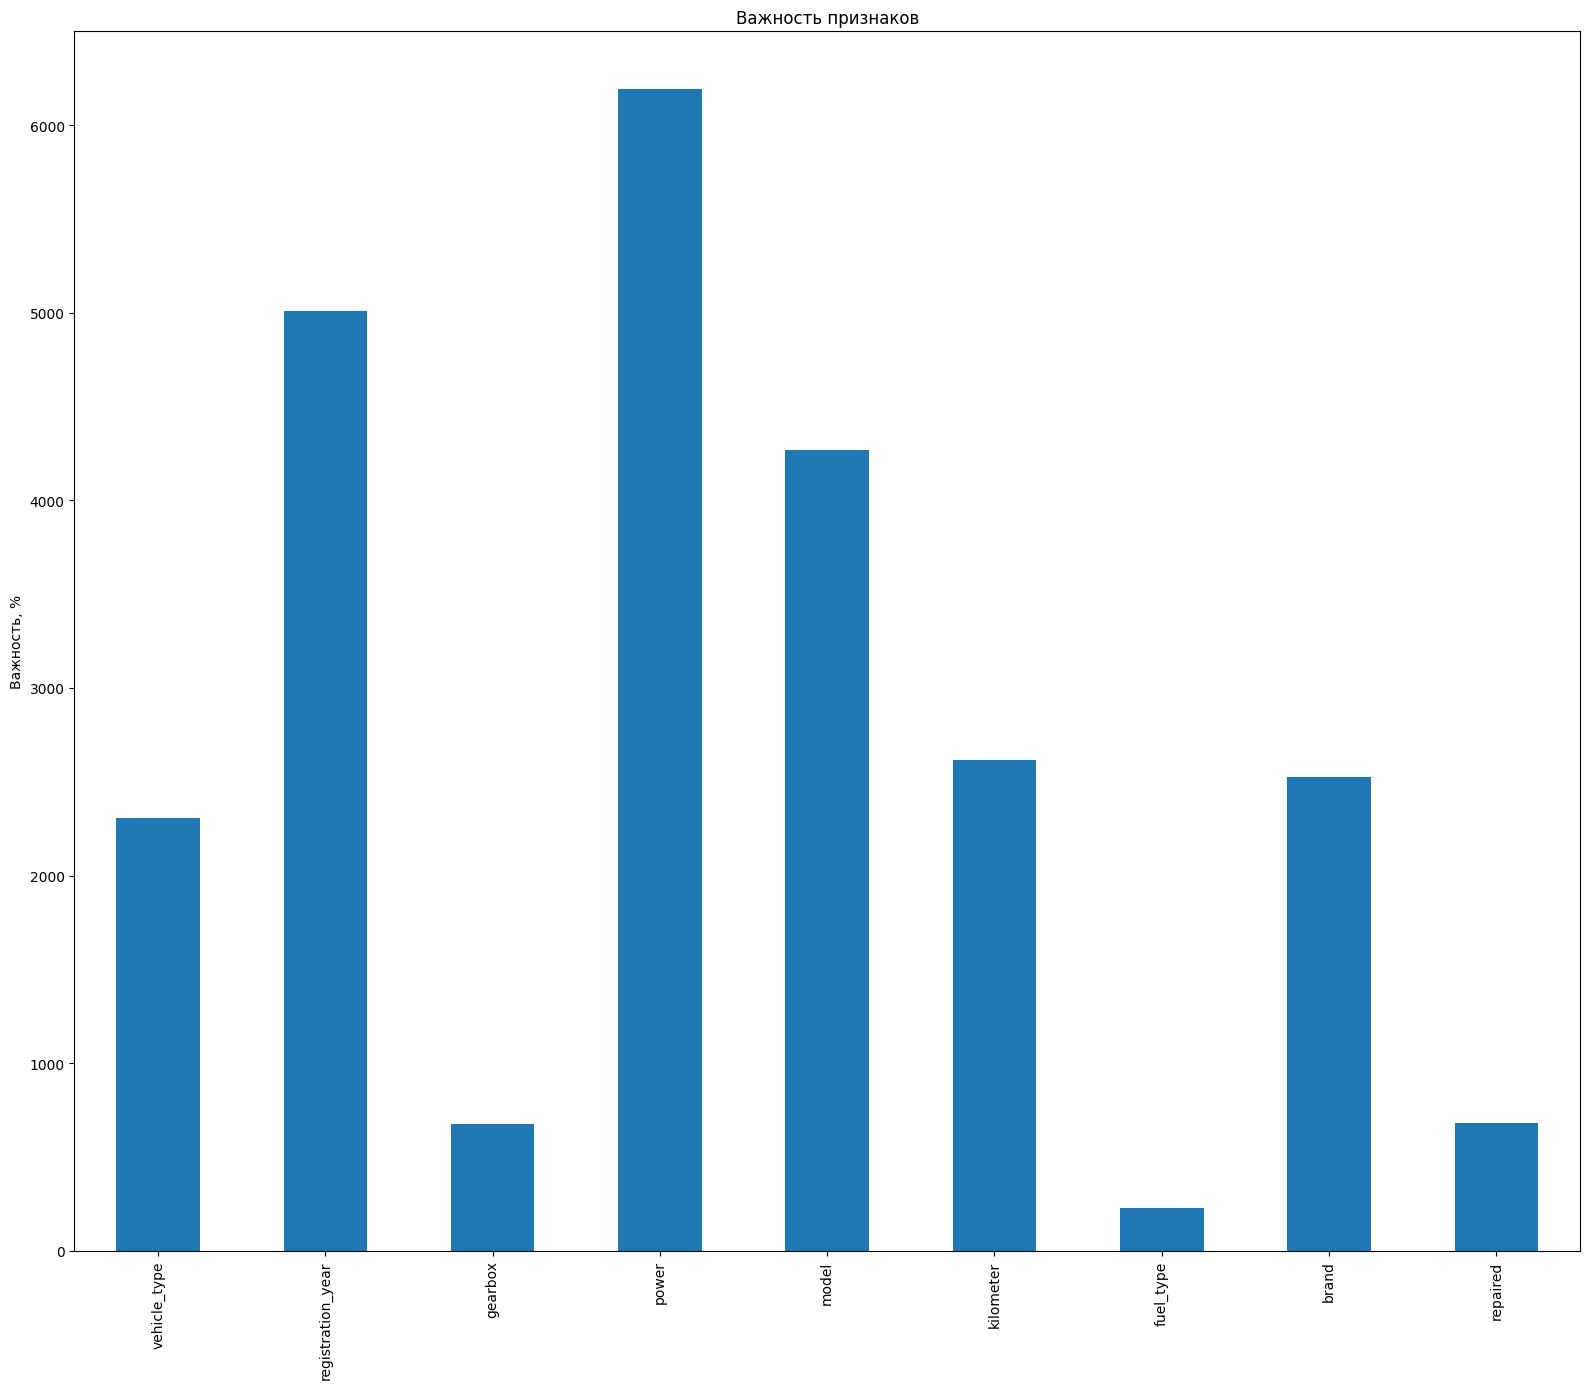

In [67]:
model_LGBMR_imp = pd.Series(model_LGBMR.feature_importances_,
                         features_train_glmme.columns)
fig, ax = plt.subplots(figsize=(16,14))
model_LGBMR_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Проверим модель на адекватность:

In [61]:


dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_glmme, target_train)
pred_dm_test = dummy_model.predict(features_test_glmme)

rsme_dummy = mean_squared_error(target_test, pred_dm_test) ** 0.5
print ('RMSE на модели DummyRegressor:', rsme_dummy)


RMSE на модели DummyRegressor: 4678.94721277105


**RMSE на модели DummyRegressor: 4678.94721277105**

## Итоговый вывод

1. Всего 15 колонок с признаками, 1 целевой признак - цена авто, всего 354369 строк, данные ограничены 2016 г включительно
2. Данные представляют собой: технические характеристики, комплектации и цены автомобилей, а также различные календарные метрики
3. Удалены признаки, которые не влияют на стоимость авто:
* DateCrawled,
* RegistrationMonth,
* NumberOfPictures,
* DateCreated
* LastSeen,
* PostalCode
4. Наименования колонок приведены к "хорошему стилю"
5. Явные дубликаты удалены. Неявные дубликаты не обнаружены
6. Пропуски в
* vehicle_type - 10.6% - поставили заглушку "unknown"
* gearbox -5.6% удалены, т к ничем нельзя заплнить - повлияет на обучение моделей
* Model - 5.6% - удалены, т к ничем нельзя заплнить - повлияет на обучение моделей
* FuelType - 9.2% - поставили заглушку "unknown"
* Repaired - 20% - проверили распределение признака, заполнили значением "yes", т к подозрительно превалирующее количество машин отмечены как "не были в ремонте"
7. Удалены выбросы и аномалии в колонках:
* price
* registration_year
* power
8. Прямая корреляция наблюдается у целевого признака с регистрацией авто, достаточно высокая с мощностью авто и обратная корреляция у целевого признака с пробегом авто
9. Всего после предобработки осталось 217242 строк, 9 колонок с признаками и 1 целевой признак
10. Данные преобразованы техникой OHE.
11. **Обучены 4 модели с подбором гиперпараметров: LightGBMRegressor, CatBoostRegressor, LinearRegression, RandomForestRegressor**
12. **Все модели прошли проверку на адекватность (RMSE на модели DummyRegressor: 4678.94721277105)**
13. **Получены результаты по контрольным метрикам, все модели удовлетворяют условию "значение метрики RMSE < 2500":**





|                    |RMSE|	Время обучения модели, s|	Скорость предсказаний, s|
|---------------------|----|------------------------|-------------------------|
|LightGBMRegressor c GLMMEncoder|	1606.475146|	4.72|	1.07|
|LightGBMRegressor c TargetEncoder|	1623.644581|	3.80|	1.05|
|CatBoostRegressor c GLMMEncoder|	1608.907793|	25.86|	0.10|
|CatBoostRegressor c TargetEncoder|	1615.374466|	25.83|	0.10|
|LinearRegression c GLMMEncoder|	2315.174070|	0.06|	0.01|
|LinearRegression c TargetEncoder|	2331.702143|	0.10|	0.01|
|RandomForestRegressor c GLMMEncoder|	1687.495371|	38.77|	1.58|
|RandomForestRegressor c TargetEncoder|	1691.391013|	38.35|	1.61|

14. **На основании контрольных показателей можно рекомендовать заказчику модель**
 * **LightGBMRegressor с гиперпараметрами (num_leaves=50, learning_rate=0.3, n_estimators=500, random_state=12345)**
 * **RMSE на лучшей модели LightGBMRegressor на тестовой выборке с GLMMEncoder: 1654.8471786704733**
 * **Время обучения: 3.83 , скорость предсказания: 1.07**
 * **Наиболее важные признаки влияющие на прогноз - мощность, год регистрации и модель авто**